In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as formula
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
#from sklearn.externals import joblib
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display

In [2]:
data = pd.read_csv('pune_19_23.csv',parse_dates =["date"])
data.head()

,City,PM2_5,PM10,NO,NO2,NOx,SO2,CO,Ozone,Benzene,...,SR,BP,VWS,Xylene,RF,TOT-RF,date,day,month,year
0,Pune,125.41,203.30,32.97,14.84,51.10,84.07,1.14,11.34,2.85,...,NaN,NaN,NaN,NaN,0.32,30.24,2019-01-01,1,1,2019
1,Pune,95.27,170.37,32.75,14.74,50.48,83.48,0.78,11.40,2.28,...,NaN,NaN,NaN,NaN,0.22,21.07,2019-02-01,2,1,2019
2,Pune,81.50,153.04,35.73,16.08,55.39,88.23,1.13,11.45,2.23,...,NaN,NaN,NaN,NaN,0.22,21.43,2019-03-01,3,1,2019
3,Pune,88.87,151.95,31.44,14.15,48.53,80.16,1.17,11.43,2.20,...,NaN,NaN,NaN,NaN,0.24,23.05,2019-04-01,4,1,2019
4,Pune,91.47,159.32,28.73,12.93,44.04,73.49,0.95,11.44,1.73,...,NaN,NaN,NaN,NaN,0.18,17.19,2019-05-01,5,1,2019


In [3]:
# drop the unwanted columns/features
cols_to_drop = ['City','RH','MP-Xylene','SR','BP','VWS','Xylene']
data = data.drop(cols_to_drop,axis=1)
# print out the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551 entries, 0 to 1550
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   PM2_5    1131 non-null   float64       
 1   PM10     1132 non-null   float64       
 2   NO       1131 non-null   float64       
 3   NO2      1170 non-null   float64       
 4   NOx      1136 non-null   float64       
 5   SO2      1131 non-null   float64       
 6   CO       1177 non-null   float64       
 7   Ozone    1128 non-null   float64       
 8   Benzene  1173 non-null   float64       
 9   Toluene  685 non-null    float64       
 10  Temp     1088 non-null   float64       
 11  WS       1169 non-null   float64       
 12  WD       1093 non-null   float64       
 13  RF       627 non-null    float64       
 14  TOT-RF   1551 non-null   float64       
 15  date     1551 non-null   datetime64[ns]
 16  day      1551 non-null   int64         
 17  month    1551 non-null   int64   

In [4]:
# check for duplicated values and null values
print('Are there any duplicated values in our data ? : {}\n'.format(data.duplicated().any()))
print('The total number of null values in each colum:')
display(data.isnull().sum())

Are there any duplicated values in our data ? : False

The total number of null values in each colum:


PM2_5      420
PM10       419
NO         420
NO2        381
NOx        415
SO2        420
CO         374
Ozone      423
Benzene    378
Toluene    866
Temp       463
WS         382
WD         458
RF         924
TOT-RF       0
date         0
day          0
month        0
year         0
dtype: int64

In [5]:
# fill in the missing values with the mean of the particular column
data.fillna(value=data.mean(),inplace=True)
# let's check the data again if there are any missing values
data.isnull().any()

PM2_5      False
PM10       False
NO         False
NO2        False
NOx        False
SO2        False
CO         False
Ozone      False
Benzene    False
Toluene    False
Temp       False
WS         False
WD         False
RF         False
TOT-RF     False
date       False
day        False
month      False
year       False
dtype: bool

In [6]:
data.head()

,PM2_5,PM10,NO,NO2,NOx,SO2,CO,Ozone,Benzene,Toluene,Temp,WS,WD,RF,TOT-RF,date,day,month,year
0,125.41,203.30,32.97,14.84,51.10,84.07,1.14,11.34,2.85,1.57,27.36,0.28,124.75,0.32,30.24,2019-01-01,1,1,2019
1,95.27,170.37,32.75,14.74,50.48,83.48,0.78,11.40,2.28,1.14,32.81,0.28,122.43,0.22,21.07,2019-02-01,2,1,2019
2,81.50,153.04,35.73,16.08,55.39,88.23,1.13,11.45,2.23,1.15,32.50,0.28,124.11,0.22,21.43,2019-03-01,3,1,2019
3,88.87,151.95,31.44,14.15,48.53,80.16,1.17,11.43,2.20,1.21,32.12,0.28,116.17,0.24,23.05,2019-04-01,4,1,2019
4,91.47,159.32,28.73,12.93,44.04,73.49,0.95,11.44,1.73,0.88,36.54,0.28,132.06,0.18,17.19,2019-05-01,5,1,2019


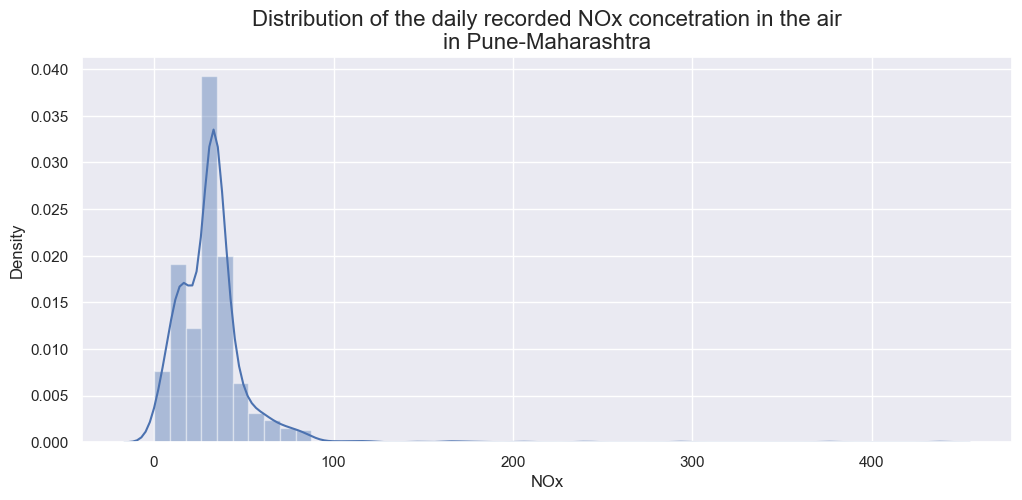

In [7]:
plt.figure(figsize=(12,5))
sns.distplot(data['NOx'],bins=50)
plt.title('Distribution of the daily recorded NOx concetration in the air\nin Pune-Maharashtra',
          fontsize=16)
plt.show()

In [8]:
import pandas as pd
import numpy as np

months = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']

# convert 'month' column to categorical variable with specified category order
monthly_data = data[['month','NOx']]
#monthly_data['month'] = pd.Categorical(monthly_data['month'], categories=months, ordered=True)

# calculate monthly median of 'PM2_5'
monthly_average = monthly_data.groupby('month')['NOx'].median()

# round the values to one decimal place
monthly_average = np.round(monthly_average, 1)

# convert the resulting Series to a DataFrame
monthly_average = pd.DataFrame(monthly_average)

# set the index to the categorical variable and rename the column
monthly_average.index.name = 'month'
monthly_average.columns = ['median_NOx']

# display the resulting DataFrame
print(monthly_average)

       median_NOx
month            
1            32.0
2            32.0
3            23.5
4            17.9
5            21.2
6            30.7
7            32.0
8            32.0
9            32.0
10           38.0
11           35.2
12           35.9


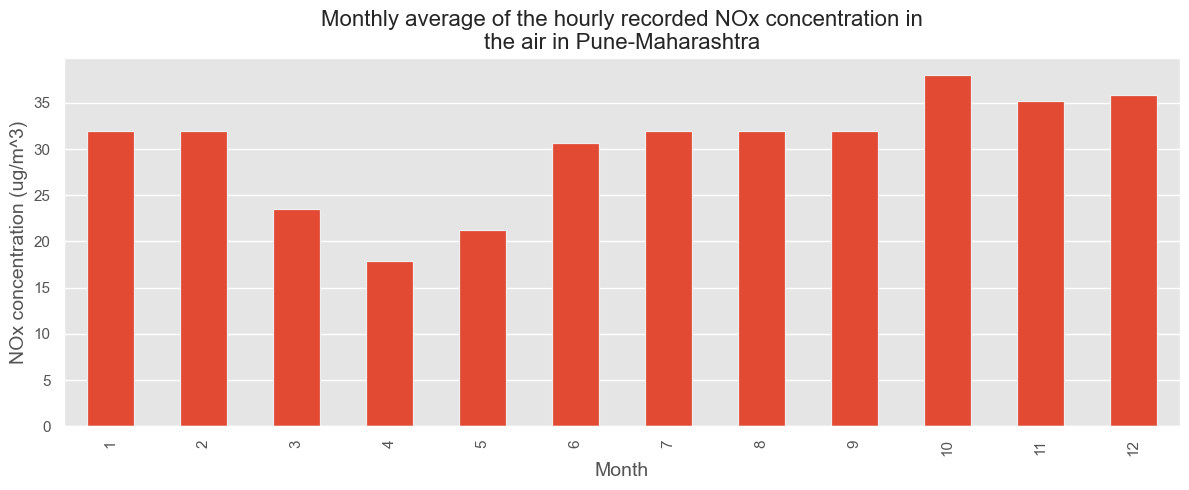

In [9]:
# plot the data
with plt.style.context('ggplot'):
    monthly_average.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Month',fontsize=14)
    plt.ylabel('NOx concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly average of the hourly recorded NOx concentration in\nthe air in Pune-Maharashtra',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

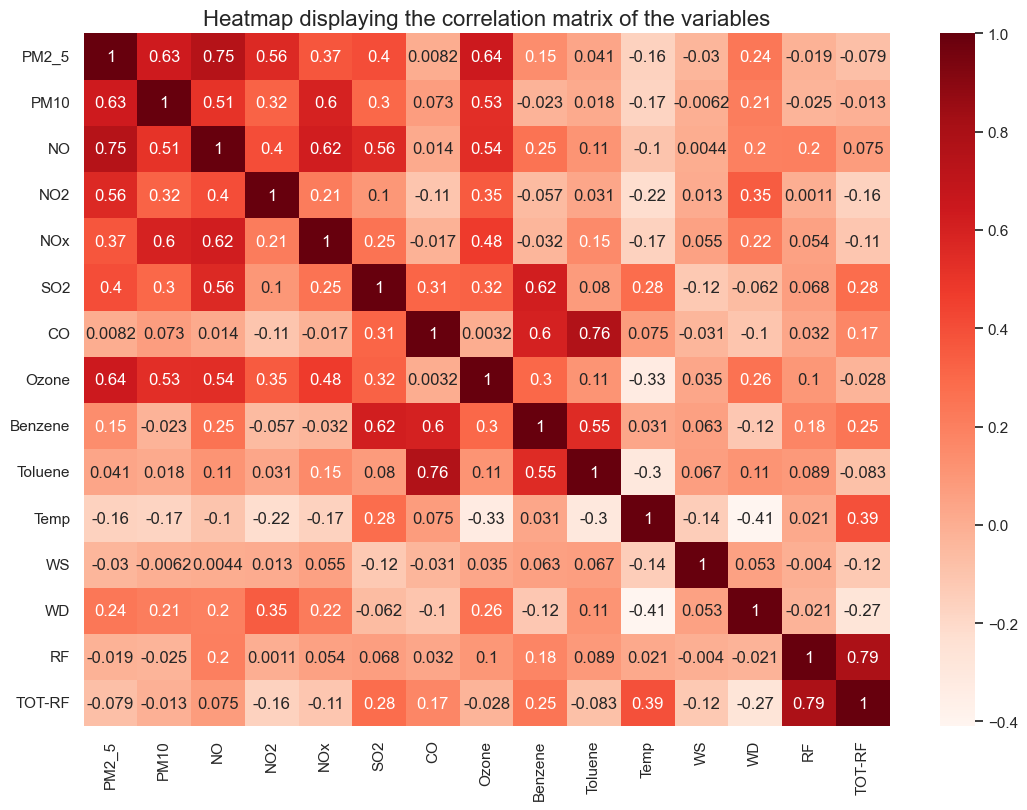

In [10]:
# let's try and visualize the relationships between the features of the data
plt.figure(figsize=(13,9))
correlation_data = data[['PM2_5', 'PM10', 'NO', 'NO2',
                         'NOx',  'SO2', 'CO',
                         'Ozone', 'Benzene', 'Toluene','Temp','WS','WD','RF','TOT-RF']]
sns.heatmap(correlation_data.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the correlation matrix of the variables',fontsize=16)
plt.show()

In [11]:
cols_to_drop = ['date','year','month','day']
newdata = data.drop(cols_to_drop,axis=1)

# calculate the variance inflation factor of each feature and detect multicollinearity
cons_data = sm.tools.add_constant(newdata)
series_before = pd.Series([variance_inflation_factor(cons_data.values,i) for i in range(cons_data.shape[1])],
                         index=cons_data.columns)
series_before

const      75.169361
PM2_5       5.732100
PM10        3.122000
NO          5.917518
NO2         1.676395
NOx         3.854137
SO2         4.316738
CO          5.469752
Ozone       2.927131
Benzene     5.051586
Toluene     6.800266
Temp        2.186631
WS          1.113640
WD          1.425789
RF          6.219123
TOT-RF      7.514249
dtype: float64

In [12]:
newdata.head()

,PM2_5,PM10,NO,NO2,NOx,SO2,CO,Ozone,Benzene,Toluene,Temp,WS,WD,RF,TOT-RF
0,125.41,203.30,32.97,14.84,51.10,84.07,1.14,11.34,2.85,1.57,27.36,0.28,124.75,0.32,30.24
1,95.27,170.37,32.75,14.74,50.48,83.48,0.78,11.40,2.28,1.14,32.81,0.28,122.43,0.22,21.07
2,81.50,153.04,35.73,16.08,55.39,88.23,1.13,11.45,2.23,1.15,32.50,0.28,124.11,0.22,21.43
3,88.87,151.95,31.44,14.15,48.53,80.16,1.17,11.43,2.20,1.21,32.12,0.28,116.17,0.24,23.05
4,91.47,159.32,28.73,12.93,44.04,73.49,0.95,11.44,1.73,0.88,36.54,0.28,132.06,0.18,17.19


In [13]:
columns_to_drop = ['WS','WD','RF','TOT-RF']

newdata = newdata.drop(columns_to_drop,axis=1)
cons_data2 = sm.tools.add_constant(newdata)
series_after = pd.Series([variance_inflation_factor(cons_data2.values,i) for i in range(cons_data2.shape[1])],
                         index=cons_data2.columns)
series_after

const      45.322363
PM2_5       5.173024
PM10        2.987089
NO          5.026243
NO2         1.594619
NOx         3.653918
SO2         3.845039
CO          4.677364
Ozone       2.830754
Benzene     4.586056
Toluene     5.731186
Temp        1.845083
dtype: float64

In [14]:
newdata.columns = ['PM2_5','PM10','NO','NO2','NOx','SO2','CO','Ozone','Benzene','Toluene','Temp']

# PM2.5 is skewed to the right so we log transform the values to normalize the distribution
newdata['NOx'] = np.log(newdata['NOx'])

In [15]:
mul_reg = formula.ols(formula="NOx ~ PM2_5  + NO + NO2 + PM10 + SO2 + CO + Ozone + Temp + Benzene + Toluene ",
                      data=newdata).fit()
mul_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    NOx   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 25 Apr 2023   Prob (F-statistic):                nan
Time:                        23:15:37   Log-Likelihood:                    nan
No. Observations:                1551   AIC:                               nan
Df Residuals:                    1540   BIC:                               nan
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept        -inf        nan        nan        nan         nan         nan
PM2_5             nan        nan        nan        nan         nan         nan
NO                inf        nan        nan        nan         nan         nan
NO2               nan        nan        nan        nan         nan         nan
PM10              nan        nan        nan        nan         nan         nan
SO2              -inf        nan        nan        nan         nan         nan
CO                nan        nan        nan        nan         nan         nan
Ozone             inf        nan        nan        nan         nan         nan
Temp              inf        nan        nan        nan         nan         nan
Benzene           inf        nan        nan        nan         nan         nan
Toluene           nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         983.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# we split the data into predictor variables and Outcome variable
X = newdata.drop('NOx',axis=1)
y = newdata['NOx']

# we need to scale or normalize the predictor variables since they are not on the same
# scale and some of their distributions are skewed.
X_scaled =  preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.dropna(inplace=True)
# print the scaled predictor variables.
X_scaled.head()

,PM2_5,PM10,NO,NO2,SO2,CO,Ozone,Benzene,Toluene,Temp
0,1.184245,2.580645,0.459140,-0.301127,1.950823,-0.515491,-0.688495,-0.265512,-0.986143,-0.790119
1,0.701889,1.936093,0.449206,-0.302156,1.928430,-0.529106,-0.685065,-0.327740,-1.028605,-0.189050
2,0.481516,1.596886,0.583762,-0.288362,2.108717,-0.515870,-0.682207,-0.333199,-1.027617,-0.223240
3,0.599464,1.575551,0.390056,-0.308229,1.802418,-0.514357,-0.683350,-0.336474,-1.021692,-0.265149
4,0.641074,1.719807,0.267692,-0.320788,1.549257,-0.522677,-0.682779,-0.387785,-1.054279,0.222323


In [17]:
y.head()

0    3.933784
1    3.921577
2    4.014399
3    3.882182
4    3.785098
Name: NOx, dtype: float64

In [29]:
# Replace large values with a more reasonable value
y[np.isinf(y)] = np.nan
y[np.isnan(y)] = np.nanmean(y)

# we now split out data into train and test data

X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.3,random_state=0)

# instantiate the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)   # fit the model

LinearRegression()

In [30]:
# we now score the model
print('Score on train data: {}\n'.format(lin_model.score(X_train,y_train)))
print('Score on test data: {}'.format(lin_model.score(X_test,y_test)))

Score on train data: 0.7181600404623916

Score on test data: 0.6451046775116183


In [31]:
prediction = lin_model.predict(X_test)
mse = mean_squared_error(y_test,prediction)
accuracy = r2_score(y_test,prediction)

print('Mean Squared Error: {}\n'.format(mse))
print('Overall model accuracy: {}'.format(accuracy))

Mean Squared Error: 380.7137937191854

Overall model accuracy: 0.6451046775116183


In [32]:
ensemble_data = data.drop(cols_to_drop,axis=1)

# we split the data into predictor variables and Outcome variable
X = ensemble_data.drop('NOx',axis=1)
y = ensemble_data['NOx']

In [33]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=.3)

In [34]:
# we go ahead to use the ensemble methods as the LinearRegression model has a low accuracy
# on both the test and train data.
decision_tree = DecisionTreeRegressor(max_depth=5,
                                     max_features='auto',
                                     min_samples_split=3,
                                     min_samples_leaf=2)
decision_tree.fit(xtrain,ytrain)

DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_leaf=2,
                      min_samples_split=3)

In [35]:
# we now score the model
print('Score on train data: {}\n'.format(decision_tree.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(decision_tree.score(xtest,ytest)))

tree_pred = decision_tree.predict(xtest)
tree_mse = mean_squared_error(ytest,tree_pred)
tree_accuracy = r2_score(ytest,tree_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_mse)))
print('Overall model accuracy: {}'.format(tree_accuracy))

Score on train data: 0.9222469706319125

Score on test data: 0.23149902931331356

Root Mean Squared Error: 18.010757431597842

Overall model accuracy: 0.23149902931331356


In [36]:
# We now tune the parameters of the model to see if we can increase the accuracy
params = {'max_depth':[3,4,5,6,7],
         'max_features':['auto','sqrt','log2'],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,9,10]}

tree = DecisionTreeRegressor()

# initialize the grid search for the best parameters
tree_search = GridSearchCV(tree,param_grid=params,
                          n_jobs=-1,cv=5)

tree_search.fit(xtrain,ytrain)   # fit the model

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [37]:
# we now score the model
print('Score on train data: {}\n'.format(tree_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(tree_search.score(xtest,ytest)))
print('Best parameters found:')
display(tree_search.best_params_)

tree_search_pred = tree_search.predict(xtest)
tree_search_mse = mean_squared_error(ytest,tree_search_pred)
tree_search_accuracy = r2_score(ytest,tree_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_search_mse)))
print('Overall model accuracy: {}'.format(tree_search_accuracy))

Score on train data: 0.9446293686364094

Score on test data: 0.12675898303844801

Best parameters found:


{'max_depth': 7,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 8}

Root Mean Squared Error: 19.198921389053467

Overall model accuracy: 0.12675898303844801


In [38]:
dtpredicted=tree_search.predict(X)
df=pd.DataFrame({'Actual':y.tolist(),'Predicted from Decision_tree':dtpredicted.tolist()})
df.to_excel('decision_tree_NOx.xlsx')

In [28]:
# instantiate the RandomForestRegressor model and fit the model on the training data
forest = RandomForestRegressor(n_estimators=100,
                              max_depth=7,
                              max_features='auto',
                              min_samples_split=7,
                              min_samples_leaf=3)

forest.fit(xtrain,ytrain)

RandomForestRegressor(max_depth=7, max_features='auto', min_samples_leaf=3,
                      min_samples_split=7)

In [29]:
# we now score the model
print('Score on train data: {}\n'.format(forest.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest.score(xtest,ytest)))

forest_pred = forest.predict(xtest)
forest_mse = mean_squared_error(ytest,forest_pred)
forest_accuracy = r2_score(ytest,forest_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_mse)))
print('Overall model accuracy: {}'.format(forest_accuracy))

Score on train data: 0.869263332603622

Score on test data: 0.6020118663177687

Root Mean Squared Error: 12.132387362184966

Overall model accuracy: 0.6020118663177687


In [30]:
# we now tune the parameters of the RandomForestRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['n_estimators'] = [100,200,300,400,500]

# instantiate the model
random_forest = RandomForestRegressor()

# perform the grid search for the best parameters
forest_search = RandomizedSearchCV(random_forest,params,n_jobs=-1,
                                   cv=5,verbose=2)
forest_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [31]:
# we now score the model
print('Score on train data: {}\n'.format(forest_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest_search.score(xtest,ytest)))
print('Best parameters found:')
display(forest_search.best_params_)

forest_search_pred = forest_search.predict(xtest)
forest_search_mse = mean_squared_error(ytest,forest_search_pred)
forest_search_accuracy = r2_score(ytest,forest_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_search_mse)))
print('Overall model accuracy: {}'.format(forest_search_accuracy))

Score on train data: 0.9027400850856613

Score on test data: 0.7194632043192595

Best parameters found:


{'n_estimators': 400,
 'min_samples_split': 7,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 6}

Root Mean Squared Error: 10.186057474265784

Overall model accuracy: 0.7194632043192595


In [32]:
rfpredicted=forest_search.predict(X)
df=pd.DataFrame({'Actual':y.tolist(),'Predicted from random_forest':rfpredicted.tolist()})
df.to_excel('randomforest_NOx.xlsx')

In [33]:
# instantiate the GradientBoostingRegressor model and fit the model on the training data
grad_boost = GradientBoostingRegressor(n_estimators=100,
                                      max_depth=7,
                                      max_features='auto',
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.1)

grad_boost.fit(xtrain,ytrain)

GradientBoostingRegressor(max_depth=7, max_features='auto', min_samples_leaf=3,
                          min_samples_split=7)

In [34]:
# we now score the model
print('Score on train data: {}\n'.format(grad_boost.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(grad_boost.score(xtest,ytest)))

gboost_pred = grad_boost.predict(xtest)
gboost_mse = mean_squared_error(ytest,gboost_pred)
gboost_accuracy = r2_score(ytest,gboost_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_mse)))
print('Overall model accuracy: {}'.format(gboost_accuracy))

Score on train data: 0.9976810724838951

Score on test data: 0.762902809372087

Root Mean Squared Error: 9.364280415928642

Overall model accuracy: 0.762902809372087


In [35]:
# we now tune the parameters of the GradientBoostingRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['learning_rate'] = np.linspace(0.1,1,10)

# instantiate the model
gradient_boosting = GradientBoostingRegressor()

# perform the grid search for the best parameters
gboost_search = RandomizedSearchCV(gradient_boosting,params,n_jobs=-1,
                                   cv=5,verbose=2)
gboost_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [36]:
# we now score the model
print('Score on train data: {}\n'.format(gboost_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(gboost_search.score(xtest,ytest)))
print('Best parameters found:')
display(gboost_search.best_params_)

gboost_search_pred = gboost_search.predict(xtest)
gboost_search_mse = mean_squared_error(ytest,gboost_search_pred)
gboost_search_accuracy = r2_score(ytest,gboost_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_search_mse)))
print('Overall model accuracy: {}'.format(gboost_search_accuracy))

Score on train data: 0.9742146444251187

Score on test data: 0.5388377652577288

Best parameters found:


{'n_estimators': 200,
 'min_samples_split': 8,
 'min_samples_leaf': 9,
 'max_features': 'sqrt',
 'max_depth': 3,
 'learning_rate': 0.1}

Root Mean Squared Error: 13.059846540420825

Overall model accuracy: 0.5388377652577288


In [37]:
xgpredicted=gboost_search.predict(X)
df=pd.DataFrame({'Actual':y.tolist(),'Predicted from Xgboost':xgpredicted.tolist()})
df.to_excel('Xgboost_NOx.xlsx')

In [38]:
xgpredicted.tolist()
print(len(y.tolist()),len(xgpredicted.tolist()))

1551 1551
